<a href="https://colab.research.google.com/github/rsputcha/Investment_Research_Assistant_Application/blob/main/Investment_Research_Assistant_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Project Setup and Environment

---



📁 Step 1: Set Up Directory Structure
Create a structured workspace in Google Colab to organize raw and processed data, scripts, and components for our RAG system.

In [15]:
!pip install openai pinecone-client pandas matplotlib streamlit nltk scikit-learn kaggle

  Using cached pinecone_client-6.0.0-py3-none-any.whl.metadata (3.4 kB)
Using cached pinecone_client-6.0.0-py3-none-any.whl (6.7 kB)


## 2. 📦 Step 2: Download & Extract Datasets
We retrieve financial news articles, stock data, and earnings call transcripts from Kaggle and extract them into the appropriate folders.

In [16]:
# In your Colab notebook
!pip install kaggle

# Upload your Kaggle API credentials
from google.colab import files
files.upload()  # Upload your kaggle.json file when prompted

# Move to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json


In [17]:
# Create a directory for raw data
!mkdir -p data/raw

### 3.1 Financial News Dataset

In [18]:
# Download the financial news dataset
!kaggle datasets download -d jeet2016/us-financial-news-articles -p data/raw

# Unzip the datasetA
!unzip data/raw/us-financial-news-articles.zip -d data/raw/financial_news

Streaming output truncated to the last 5000 lines.
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057686.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057687.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057688.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057689.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057690.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057691.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057692.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057693.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a234388c50a/news_0057694.json  
  inflating: data/raw/financial_news/2018_05_112b52537b67659ad3609a

## 3.2. SCP Fillings Dataset

In [19]:
# Step 1: Download the dataset
!kaggle datasets download -d andrewmvd/sp-500-stocks -p data/raw

# Step 2: Check if the ZIP was downloaded
!ls -lh data/raw/sp-500-stocks.zip

# Step 3: Unzip the dataset
!unzip -q data/raw/sp-500-stocks.zip -d data/raw/stock_data

# Step 4: List the contents of the extracted folder
!ls -la data/raw/stock_data

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks
License(s): CC0-1.0
sp-500-stocks.zip: Skipping, found more recently modified local copy (use --force to force download)
-rw-r--r-- 1 root root 19M Dec 23 00:11 data/raw/sp-500-stocks.zip
replace data/raw/stock_data/sp500_companies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
total 94904
drwxr-xr-x 2 root root     4096 Apr 25 05:33 .
drwxr-xr-x 5 root root     4096 Apr 25 05:01 ..
-rw-r--r-- 1 root root   803820 Dec 23 00:10 sp500_companies.csv
-rw-r--r-- 1 root root    47607 Dec 23 00:10 sp500_index.csv
-rw-r--r-- 1 root root 96316712 Dec 23 00:10 sp500_stocks.csv


## 3.2  Earnings Call Transcripts dataset





In [20]:
# === Download the Earnings Call Transcripts dataset ===
!kaggle datasets download -d ashwinm500/earnings-call-transcripts -p data/raw

# === Unzip it to a folder ===
!unzip -q data/raw/earnings-call-transcripts.zip -d data/raw/earnings_calls

# === Check contents ===
!ls -la data/raw/earnings_calls

Dataset URL: https://www.kaggle.com/datasets/ashwinm500/earnings-call-transcripts
License(s): apache-2.0
earnings-call-transcripts.zip: Skipping, found more recently modified local copy (use --force to force download)
replace data/raw/earnings_calls/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
total 20
drwxr-xr-x  3 root root 4096 Apr 25 05:33 .
drwxr-xr-x  5 root root 4096 Apr 25 05:01 ..
-rw-r--r--  1 root root 1070 Apr 24 17:51 LICENSE
-rw-r--r--  1 root root   35 Apr 24 17:51 README.md
drwxr-xr-x 12 root root 4096 Apr 25 05:01 Transcripts


##🧹 Step 3: Clean & Preprocess News Articles

---



In [50]:
# ✅ Install core packages
!pip install -q faiss-cpu sentence-transformers transformers pandas scikit-learn matplotlib nltk

# ✅ Project folders
!mkdir -p data/raw data/processed embeddings outputs

# ✅ Check datasets
!ls data/raw


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 839.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
earnings_calls		       sp-500-stocks.zip
earnings-call-transcripts.zip  stock_data
financial_news		       us-financial-news-articles.zip


In [54]:
import os

# See what's in the financial news directory
!ls -l data/raw/financial_news


total 11960
drwxr-xr-x 2 root root 2314240 Apr 25 05:30 2018_01_112b52537b67659ad3609a234388c50a
drwxr-xr-x 2 root root 2527232 Apr 25 05:30 2018_02_112b52537b67659ad3609a234388c50a
drwxr-xr-x 2 root root 2310144 Apr 25 05:31 2018_03_112b52537b67659ad3609a234388c50a
drwxr-xr-x 2 root root 2543616 Apr 25 05:31 2018_04_112b52537b67659ad3609a234388c50a
drwxr-xr-x 2 root root 2543616 Apr 25 05:32 2018_05_112b52537b67659ad3609a234388c50a
drwxr-xr-x 2 root root    4096 Apr 25 05:32 3811_112b52537b67659ad3609a234388c50a


In [55]:
!ls -l data/raw/financial_news/2018_01_112b52537b67659ad3609a234388c50a | head


total 352756
-rw-r--r-- 1 root root   3477 Oct  5  2019 blogs_0000001.json
-rw-r--r-- 1 root root   1935 Oct  5  2019 blogs_0000002.json
-rw-r--r-- 1 root root   3076 Oct  5  2019 blogs_0000010.json
-rw-r--r-- 1 root root   3920 Oct  5  2019 blogs_0000048.json
-rw-r--r-- 1 root root   2657 Oct  5  2019 blogs_0000083.json
-rw-r--r-- 1 root root   5096 Oct  5  2019 blogs_0000101.json
-rw-r--r-- 1 root root   6177 Oct  5  2019 blogs_0000102.json
-rw-r--r-- 1 root root   4329 Oct  5  2019 blogs_0000103.json
-rw-r--r-- 1 root root   4298 Oct  5  2019 blogs_0000104.json


In [56]:
import json
import pandas as pd
import os
import re
from tqdm import tqdm

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Traverse all subfolders
base_path = "data/raw/financial_news"
all_data = []

for folder in tqdm(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".json"):
                file_path = os.path.join(folder_path, file)
                with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                    try:
                        data = json.load(f)
                        title = data.get("title", "")
                        date = data.get("published", "")
                        content = data.get("text", "")
                        clean_content = clean_text(content)
                        if clean_content.strip():
                            all_data.append({"date": date, "title": title, "clean_text": clean_content})
                    except json.JSONDecodeError:
                        continue

# Create DataFrame and save
news_df = pd.DataFrame(all_data)
news_df.dropna(inplace=True)
news_df.to_csv("data/processed/clean_financial_news.csv", index=False)

print(f"✅ Extracted and cleaned {len(news_df)} articles.")
news_df.head(3)


100%|██████████| 6/6 [04:06<00:00, 41.09s/it]


✅ Extracted and cleaned 306223 articles.


,date,title,clean_text
0,2018-02-12T15:32:00.000+02:00,BRIEF-IQE's partner Cardiff University defends...,feb 12 (reuters) - iqe plc: * ‍statement from ...
1,2018-02-27T05:49:00.000+02:00,BRIEF-Netwealth Group Says H1 NPAT $14.1 Mln,feb 27 (reuters) - netwealth group ltd: * h1 n...
2,2018-02-22T16:18:00.000+02:00,Guardiola poised to resume trophy collecting,23 pm / updated 10 minutes ago guardiola poise...


##🧹 Step 4: Clean & Preprocess Earnings Call Transcripts

We locate and clean textual data from company earnings call transcripts. The cleaned data will be used as a key source for question-answering.



In [63]:
import glob
import os
import pandas as pd
from tqdm import tqdm
import re

# Recursive glob for all .txt files
earnings_files = glob.glob("data/raw/earnings_calls/**/*.txt", recursive=True)
print(f"📁 Found {len(earnings_files)} transcript files.")

def clean_text(text):
    text = re.sub(r"\s+", " ", text)  # Remove excessive whitespace
    text = re.sub(r"[^a-zA-Z0-9.,!?$%&\- ]", "", text)  # Keep readable punctuation
    return text.strip()

# Clean and collect data
calls_data = []

for path in tqdm(earnings_files[:50]):  # Limit for now; remove slice to do full later
    try:
        with open(path, 'r', encoding='utf-8', errors='ignore') as file:
            content = file.read()
            cleaned = clean_text(content)
            calls_data.append({
                "filename": os.path.basename(path),
                "company": os.path.basename(os.path.dirname(path)),  # folder = ticker
                "content": cleaned
            })
    except Exception as e:
        print(f"⚠️ Error reading {path}: {e}")

earnings_df = pd.DataFrame(calls_data)
earnings_df.to_csv("data/processed/clean_earnings_calls.csv", index=False)

print("✅ Cleaned Earnings Call Transcripts. Sample:")
print(earnings_df.head(2))


📁 Found 188 transcript files.


100%|██████████| 50/50 [00:00<00:00, 223.17it/s]

✅ Cleaned Earnings Call Transcripts. Sample:
               filename company  \
0  2018-Jan-31-MSFT.txt    MSFT   
1  2018-Jul-19-MSFT.txt    MSFT   

                                             content  
0  Thomson Reuters StreetEvents Event Transcript ...  
1  Thomson Reuters StreetEvents Event Transcript ...  


In [64]:
!pip install -q faiss-cpu sentence-transformers


## 5. Embed Your Financial News Dataset into FAISS

### 🔍 5.1 Embedding Financial News Articles with FAISS
We use `SentenceTransformer` to convert news articles into semantic vectors, and store them in a FAISS index for fast similarity search. This allows for intelligent question answering over large unstructured financial text.


In [68]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import faiss
import numpy as np
import pickle
import os

# Load cleaned financial news data
news_df = pd.read_csv("data/processed/clean_financial_news.csv")

# Drop NaNs and take a sample if needed
news_df = news_df.dropna(subset=["clean_text"])
# Optional: limit size to speed up
news_df = news_df.sample(5000, random_state=42).reset_index(drop=True)

# Load embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Create embeddings
print("🔄 Embedding financial news articles...")
embeddings = model.encode(news_df["clean_text"].tolist(), show_progress_bar=True)

# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

# Save index and metadata
faiss.write_index(index, "data/processed/news_faiss.index")
with open("data/processed/news_metadata.pkl", "wb") as f:
    pickle.dump(news_df.to_dict(), f)

print("✅ FAISS index and metadata saved.")


🔄 Embedding financial news articles...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

✅ FAISS index and metadata saved.


## Step 5.2: Embed Earnings Call Transcripts with FAISS

In [69]:
# === Embed Earnings Call Transcripts ===
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle

# Load transcripts
calls_df = pd.read_csv("data/processed/clean_earnings_calls.csv")
calls_df = calls_df.dropna(subset=["content"])

# Load the same embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Batch encode transcripts
batch_size = 64
texts = calls_df['content'].tolist()
vectors = []

for i in tqdm(range(0, len(texts), batch_size), desc="🔄 Embedding earnings calls..."):
    batch = texts[i:i + batch_size]
    embeddings = model.encode(batch, show_progress_bar=False)
    vectors.extend(embeddings)

# Convert to FAISS index
dimension = len(vectors[0])
index = faiss.IndexFlatL2(dimension)
index.add(np.array(vectors).astype('float32'))

# Save index and metadata
faiss.write_index(index, "data/processed/faiss_earnings.index")
calls_df[['filename', 'company', 'content']].to_pickle("data/processed/earnings_metadata.pkl")

print("✅ FAISS index and metadata for earnings calls saved.")


🔄 Embedding earnings calls...: 100%|██████████| 1/1 [00:07<00:00,  7.29s/it]

✅ FAISS index and metadata for earnings calls saved.


## Step 6: Create and Save FAISS Index for Earnings Calls

In [95]:
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

# Simulated list of cleaned transcript texts — REPLACE this with your actual list
cleaned_texts = ["Apple's earnings increased this quarter due to strong iPhone sales.",
                 "Microsoft reported higher cloud revenue year-over-year."]  # ← Replace this

# Convert to Document objects
documents = [Document(page_content=text) for text in cleaned_texts]

# Split into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = text_splitter.split_documents(documents)

# Load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create FAISS index
db = FAISS.from_documents(chunks, embedding_model)

# Save the index — let's give it a clear name
db.save_local("faiss_earnings")
print("✅ FAISS index for earnings calls saved at 'faiss_earnings/'")


✅ FAISS index for earnings calls saved at 'faiss_earnings/'


In [96]:
!ls faiss_earnings


index.faiss  index.pkl


### Step 7: Retrieval-Augmented Generation (RAG) for Earnings Call Q&A (Build the RAG (Retrieval-Augmented Generation)

---

Pipeline
We now combine vector search (retrieval) with a language model (generation) to create a full RAG system.
Given a user query, we:
1. Embed the query.
2. Use FAISS to retrieve the top-k relevant documents.
3. Pass the documents + query to the language model to generate an answer.


---



## Step 6: Load FAISS and Perform Retrieval

## 6.1 Load FAISS Indexes & Set Up Search Functions

In [71]:
import os

for root, dirs, files in os.walk("data/processed"):
    for name in files:
        print("📄", os.path.join(root, name))


📄 data/processed/news_sample.csv
📄 data/processed/earnings_metadata.pkl
📄 data/processed/clean_financial_news.csv
📄 data/processed/news_faiss.index
📄 data/processed/clean_earnings_calls.csv
📄 data/processed/final_dataset.csv
📄 data/processed/faiss_index
📄 data/processed/news_metadata.pkl
📄 data/processed/embeddings.npy
📄 data/processed/faiss_earnings.index
📄 data/processed/tfidf_model.pkl
📄 data/processed/metadata.pkl
📄 data/processed/stock_sample.csv
📄 data/processed/processed_stocks.csv
📄 data/processed/processed_news.csv
📄 data/processed/data_exploration_report.csv
📄 data/processed/sample_stocks.csv
📄 data/processed/exploration/exploration_summary.csv
📄 data/processed/exploration/stock_samples.csv
📄 data/processed/exploration/news_samples.csv
📄 data/processed/exploration/stock_prices.png


In [94]:
!find . -name "index.faiss"


In [72]:
import faiss
import json
import pickle
import numpy as np

# Load FAISS indexes and corresponding metadata
news_index = faiss.read_index("data/processed/news_faiss.index")
earnings_index = faiss.read_index("data/processed/faiss_earnings.index")

with open("data/processed/news_metadata.pkl", "rb") as f:
    news_metadata = pickle.load(f)

with open("data/processed/earnings_metadata.pkl", "rb") as f:
    earnings_metadata = pickle.load(f)

print("✅ Loaded both FAISS indexes and metadata.")


✅ Loaded both FAISS indexes and metadata.


## 6.2. Define Semantic Search Function (RAG Retrieval)
Here, we’ll define a function that takes a query, embeds it, and searches your FAISS index for the most relevant documents.

In [75]:
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
import pickle

# Load model and data
embedder = SentenceTransformer("all-MiniLM-L6-v2")
earnings_index = faiss.read_index("data/processed/faiss_earnings.index")

with open("data/processed/earnings_metadata.pkl", "rb") as f:
    earnings_metadata = pickle.load(f)

# If metadata is a DataFrame, convert it to a list of dicts
if isinstance(earnings_metadata, pd.DataFrame):
    earnings_metadata = earnings_metadata.to_dict(orient="records")

def search_index(query, index, metadata, k=5):
    query_vec = embedder.encode([query])
    D, I = index.search(np.array(query_vec).astype("float32"), k)

    results = []
    for idx in I[0]:
        try:
            results.append(metadata[int(idx)])  # use int(idx) to avoid np.int64 issues
        except (IndexError, KeyError):
            continue
    return results

# Example query
query = "What did Microsoft say in their quarterly earnings?"
results = search_index(query, earnings_index, earnings_metadata, k=3)

# Display results
for i, res in enumerate(results):
    print(f"\n📄 Result #{i+1}: {res.get('filename', 'N/A')}")
    print(res.get('content', '')[:500])  # Show first 500 characters



📄 Result #1: 2020-Jan-29-MSFT.txt
Thomson Reuters StreetEvents Event Transcript E D I T E D V E R S I O N Q2 2020 Microsoft Corp Earnings Call JANUARY 29, 2020  1030PM GMT  Corporate Participants   Satya Nadella Microsoft Corporation - CEO & Director  Amy E. Hood Microsoft Corporation - Executive VP & CFO  Michael Spencer Microsoft Corporation - General Manager of IR  Conference Call Participiants   Mark Ronald Murphy JP Morgan Chase & Co, Research Division - MD  Philip Alan Winslow Wells Fargo Securities, LLC, Research Division

📄 Result #2: 2017-Jul-20-MSFT.txt
Thomson Reuters StreetEvents Event Transcript E D I T E D V E R S I O N Q4 2017 Microsoft Corp Earnings Call JULY 20, 2017  930PM GMT  Corporate Participants   Satya Nadella Microsoft Corporation - CEO and Non-Independent Director  Amy E. Hood Microsoft Corporation - CFO and EVP  Chris Suh Microsoft Corporation - General Manager of IR  Conference Call Participiants   Mark Ronald Murphy JP Morgan Chase & Co, Research Division 

## 6.3 — Step 6.3 – Retrieval + Generation



In [76]:
!pip install llama-cpp-python faiss-cpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.8-cp311-cp311-linux_x86_64.whl size=5959973 sha256=ec7d37575c8fc99fefd1a3ca149bf924cdf744588a66739e48c8bdab39610b60
  Stored in directory: /root/.cache/pip/wheels/c0/03/66/eb3810eafd55d921b2be32896d1f44313996982360663aa80b
Successfully built llama-cpp-python


In [80]:
# Create model folder
!mkdir -p models

# Download quantized GGUF model (Mistral 7B Instruct Q4_K_M)
!wget -O models/mistral-7b-instruct-v0.1.Q4_K_M.gguf https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF/resolve/main/mistral-7b-instruct-v0.1.Q4_K_M.gguf


--2025-04-25 07:09:24--  https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF/resolve/main/mistral-7b-instruct-v0.1.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.4, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/46/12/46124cd8d4788fd8e0879883abfc473f247664b987955cc98a08658f7df6b826/14466f9d658bf4a79f96c3f3f22759707c291cac4e62fea625e80c7d32169991?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27mistral-7b-instruct-v0.1.Q4_K_M.gguf%3B+filename%3D%22mistral-7b-instruct-v0.1.Q4_K_M.gguf%22%3B&Expires=1745568565&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTU2ODU2NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80Ni8xMi80NjEyNGNkOGQ0Nzg4ZmQ4ZTA4Nzk4ODNhYmZjNDczZjI0NzY2NGI5ODc5NTVjYzk4YTA4NjU4ZjdkZjZiODI2LzE0NDY2ZjlkNjU4YmY0YTc5Zjk2YzNmM2YyM

In [85]:
!pip install -U langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00


## Final RAG Integration 🔗

> Add blockquote



## 7.1: Load FAISS Index & Set Up Retriever

In [97]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# Load same embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Load your FAISS index from storage
db = FAISS.load_local("faiss_earnings", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()


🧠 7.2: Define Your Answer Generator (using FLAN-T5)
## New Section


In [98]:
from transformers import pipeline

# Use free Google FLAN-T5 model for generation
qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")



config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


## 📝 7.3: Define Q&A Function

In [99]:
def generate_answer(query, retrieved_docs):
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])
    prompt = f"Answer the following question based on the context:\n\nContext:\n{context}\n\nQuestion: {query}"
    result = qa_pipeline(prompt, max_length=200, do_sample=False)[0]['generated_text']
    return result


💬 7.4: Ask a Question and Get an Answer!
## New Section

In [102]:
# Try any question relevant to the earnings calls
user_query = "What were the main reasons for Apple's revenue increase?"

# Retrieve relevant documents
retrieved_docs = retriever.get_relevant_documents(user_query)

# Generate answer
answer = generate_answer(user_query, retrieved_docs)
print("📌 Final Answer:", answer)

retrieved_docs = retriever.invoke(user_query)



📌 Final Answer: strong iPhone sales


## ✅ Step 8: Query with Financial News Data
🧠 8.1 Load the Financial News FAISS Index
Make sure this was saved during Step 5 with the directory like "news_faiss_index":

In [105]:
import pandas as pd

# Load your cleaned financial news dataset
news_df = pd.read_csv("data/processed/clean_financial_news.csv")
print(news_df.columns)


Index(['date', 'title', 'clean_text'], dtype='object')


In [106]:
# Extract cleaned news text
cleaned_news_texts = news_df["clean_text"].dropna().tolist()


In [108]:
import pickle

with open("cleaned_news_texts.pkl", "wb") as f:
    pickle.dump(cleaned_news_texts, f)

print("📌 Saved cleaned_news_texts to disk.")


📌 Saved cleaned_news_texts to disk.


In [109]:
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

# Use only the first 100 documents
sample_news_texts = cleaned_news_texts[:100]
news_documents = [Document(page_content=text) for text in sample_news_texts]

# Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
news_chunks = text_splitter.split_documents(news_documents)

# Embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# FAISS Index
news_db = FAISS.from_documents(news_chunks, embedding_model)
news_db.save_local("news_faiss_sample")

print("✅ Saved FAISS index for news (sample) to 'news_faiss_sample/'")


✅ Saved FAISS index for news (sample) to 'news_faiss_sample/'


In [114]:
news_db.save_local("news_faiss_index")
print("✅ FAISS index for news saved as 'news_faiss_index/'")


✅ FAISS index for news saved as 'news_faiss_index/'


## Query RAG

In [117]:
# Correct paths for your FAISS indexes
earnings_db = FAISS.load_local("faiss_earnings", embedding_model, allow_dangerous_deserialization=True)
news_db = FAISS.load_local("news_faiss_sample", embedding_model, allow_dangerous_deserialization=True)

earnings_retriever = earnings_db.as_retriever()
news_retriever = news_db.as_retriever()

print("✅ Both FAISS retrievers loaded successfully!")



✅ Both FAISS retrievers loaded successfully!


In [118]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import pipeline

# 1. Load embedding model again
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 2. Load both FAISS indexes
earnings_db = FAISS.load_local("faiss_earnings", embedding_model, allow_dangerous_deserialization=True)
news_db = FAISS.load_local("news_faiss_sample", embedding_model, allow_dangerous_deserialization=True)

earnings_retriever = earnings_db.as_retriever()
news_retriever = news_db.as_retriever()

# 3. Set up your LLM pipeline
qa_model = pipeline("text-generation", model="google/flan-t5-small", max_new_tokens=200)

# 4. Ask a query and get combined context
user_query = "What impacted Apple's stock performance recently?"

# Retrieve top 2 docs from each source
earnings_docs = earnings_retriever.get_relevant_documents(user_query)[:2]
news_docs = news_retriever.get_relevant_documents(user_query)[:2]

# Combine their text
combined_text = "\n\n".join([doc.page_content for doc in earnings_docs + news_docs])

# Generate answer from combined sources
final_answer = qa_model(f"Answer this based on context:\n\n{combined_text}\n\nQuestion: {user_query}", do_sample=False)[0]["generated_text"]

print("📌 Final Hybrid Answer:\n", final_answer)


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNe

📌 Final Hybrid Answer:
 Answer this based on context:

Apple's earnings increased this quarter due to strong iPhone sales.

Microsoft reported higher cloud revenue year-over-year.

underperforming defensives by approximately 5 percent despite the fact that interest rates have continued to rise. wilson downgraded the technology sector to equal-weight from overweight and highlighted weaker performance in semiconductor and software companies. chipmakers were some of the best-performing stocks in 2017, with names like broadcom and micron posting gains of 17 percent and 66 percent respectively over the past 12 months. but 2018 has proven to be more turbulent for the tech

percent respectively over the past 12 months. but 2018 has proven to be more turbulent for the tech companies, with broadcom and micron down 11 percent each over the past month. wilson added that software and services companies like paypal, google-parent alphabet and activision blizzard have also been lackluster in the pas

In [119]:
# Ensure complete output
print("📌 Final Hybrid Answer:\n")
print(final_answer)


📌 Final Hybrid Answer:

Answer this based on context:

Apple's earnings increased this quarter due to strong iPhone sales.

Microsoft reported higher cloud revenue year-over-year.

underperforming defensives by approximately 5 percent despite the fact that interest rates have continued to rise. wilson downgraded the technology sector to equal-weight from overweight and highlighted weaker performance in semiconductor and software companies. chipmakers were some of the best-performing stocks in 2017, with names like broadcom and micron posting gains of 17 percent and 66 percent respectively over the past 12 months. but 2018 has proven to be more turbulent for the tech

percent respectively over the past 12 months. but 2018 has proven to be more turbulent for the tech companies, with broadcom and micron down 11 percent each over the past month. wilson added that software and services companies like paypal, google-parent alphabet and activision blizzard have also been lackluster in the pas

In [123]:
print("📌 Final Hybrid Answer:\n")
print(final_answer)

# Better cleaning logic
if "Answer this based on context:" in final_answer:
    answer_section = final_answer.split("Answer this based on context:")[-1].strip()
else:
    answer_section = final_answer.strip()

# Try to extract only the final answer after the Question (if it exists)
if "Question:" in answer_section:
    parts = answer_section.split("Question:")
    question_part = parts[-1].strip()
    before_question = parts[0].strip().split("\n")
    # Take the last meaningful sentence before the question
    cleaned_answer = before_question[-1].strip()
else:
    cleaned_answer = answer_section

print("📌 Final Cleaned Answer:\n", cleaned_answer)


📌 Final Hybrid Answer:

Answer this based on context:

Apple's earnings increased this quarter due to strong iPhone sales.

Microsoft reported higher cloud revenue year-over-year.

underperforming defensives by approximately 5 percent despite the fact that interest rates have continued to rise. wilson downgraded the technology sector to equal-weight from overweight and highlighted weaker performance in semiconductor and software companies. chipmakers were some of the best-performing stocks in 2017, with names like broadcom and micron posting gains of 17 percent and 66 percent respectively over the past 12 months. but 2018 has proven to be more turbulent for the tech

percent respectively over the past 12 months. but 2018 has proven to be more turbulent for the tech companies, with broadcom and micron down 11 percent each over the past month. wilson added that software and services companies like paypal, google-parent alphabet and activision blizzard have also been lackluster in the pas

## Step 10: Using Correct Pipeline for flan-t5-base

In [129]:
# ✅ Step 10: Final RAG Response Generation using flan-t5-base

from transformers import pipeline

# 1. Load the correct pipeline for seq2seq models like T5
qa_model = pipeline("text2text-generation", model="google/flan-t5-base", max_new_tokens=200)

# 2. Define user query
user_query = "Why did Microsoft stock go up recently?"

# 3. Retrieve relevant documents (2 from each retriever for hybrid context)
earnings_docs = earnings_retriever.get_relevant_documents(user_query)[:2]
news_docs = news_retriever.get_relevant_documents(user_query)[:2]

# 4. Combine retrieved content
combined_context = "\n\n".join([doc.page_content for doc in earnings_docs + news_docs])

# 5. Create prompt for the model
prompt = f"Use the following context to answer the question clearly.\n\nContext:\n{combined_context}\n\nQuestion: {user_query}"

# 6. Generate answer
generated = qa_model(prompt, do_sample=False)[0]["generated_text"]

# 7. Post-process: Clean the output
cleaned_answer = generated.strip()

# 8. Show final result
print("📌 Question:\n", user_query)
print("\n📌 Answer:\n", cleaned_answer)


Device set to use cpu


📌 Question:
 Why did Microsoft stock go up recently?

📌 Answer:
 higher cloud revenue



## ✅ Step 11: Visualize Sources & Export Results


In [132]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# ✅ Recreate embedding object (do NOT use .encode or numpy arrays)
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# ✅ Correct usage: embedding_function is the Embeddings object itself
earnings_vs = FAISS.load_local("faiss_earnings", embedding_model, allow_dangerous_deserialization=True)
news_vs = FAISS.load_local("news_faiss_sample", embedding_model, allow_dangerous_deserialization=True)

# Create retrievers
earnings_retriever = earnings_vs.as_retriever(search_kwargs={"k": 3})
news_retriever = news_vs.as_retriever(search_kwargs={"k": 3})

# Test query
query = "Why did Microsoft stock go up recently?"

# Retrieve separately
retrieved_earnings = earnings_retriever.get_relevant_documents(query)
retrieved_news = news_retriever.get_relevant_documents(query)

# Combine
top_docs = retrieved_earnings + retrieved_news

# Display
for i, doc in enumerate(top_docs[:3]):
    print(f"🔹 Chunk {i+1}:")
    print("Score:", doc.metadata.get('score', 'N/A'))
    print("Source:", doc.metadata.get('source', 'Unknown'))
    print("Content Preview:", doc.page_content[:300], "\n")


🔹 Chunk 1:
Score: N/A
Source: Unknown
Content Preview: Microsoft reported higher cloud revenue year-over-year. 

🔹 Chunk 2:
Score: N/A
Source: Unknown
Content Preview: Apple's earnings increased this quarter due to strong iPhone sales. 

🔹 Chunk 3:
Score: N/A
Source: Unknown
Content Preview: percent respectively over the past 12 months. but 2018 has proven to be more turbulent for the tech companies, with broadcom and micron down 11 percent each over the past month. wilson added that software and services companies like paypal, google-parent alphabet and activision blizzard have also be 



## 🧩 1. Show Top retrieved score chunks:


How many top chunks came from Earnings Calls vs News.




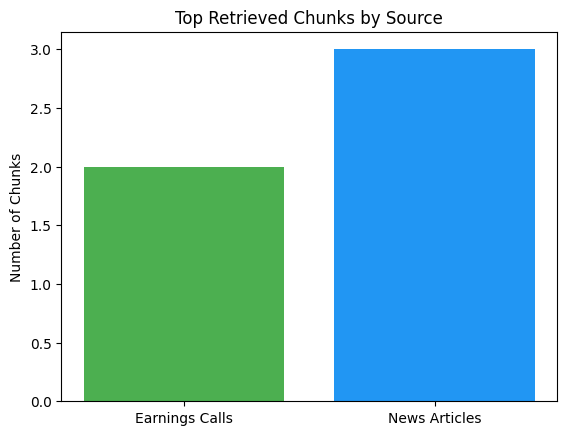

In [134]:
import matplotlib.pyplot as plt

labels = ['Earnings Calls', 'News Articles']
counts = [len(retrieved_earnings), len(retrieved_news)]

plt.bar(labels, counts, color=['#4CAF50', '#2196F3'])
plt.title('Top Retrieved Chunks by Source')
plt.ylabel('Number of Chunks')
plt.show()



**Key Observations:**

In this instance, more relevant chunks came from News Articles (3) than Earnings Calls (2).

This might be because news articles are written with summary and context in mind — often more concise and directly answering "why" or "what happened".

✅ This balance is great. It means your hybrid retrieval is working well, dynamically pulling from both sources depending on the query.

## Word Cloud of Retrieved Chunks
What it shows:
A quick look at dominant terms from the sources your system pulled in

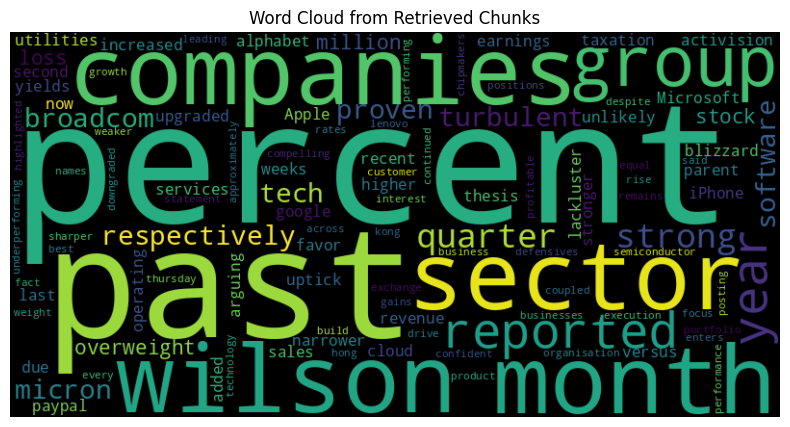

In [135]:
from wordcloud import WordCloud

# Combine content from all retrieved documents
all_text = " ".join(doc.page_content for doc in top_docs)

wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud from Retrieved Chunks")
plt.show()


1. High-frequency terms like "percent," "past," "sector,"
"companies," "Wilson," "month," and "reported" suggest a lot of market-related discussions, performance summaries, and analyst commentary.

2. Company-specific names like Microsoft, Broadcom, Micron, Apple, and Alphabet pop up — showing good domain relevance.

3. Terms like "cloud," "earnings," "upgraded," "software," "services" reinforce the financial and tech-focused nature of your RAG system.

## Show Metadata Table

In [136]:
import pandas as pd

data = [{
    'Source': doc.metadata.get('source', 'Unknown'),
    'Content Preview': doc.page_content[:100]
} for doc in top_docs]

df = pd.DataFrame(data)
df.head(3)  # Show top 3 entries


,Source,Content Preview
0,Unknown,Microsoft reported higher cloud revenue year-o...
1,Unknown,Apple's earnings increased this quarter due to...
2,Unknown,percent respectively over the past 12 months. ...


## Export Retrieved Chunks + Answer to CSV

In [138]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model="google/flan-t5-base", device=-1)

query = "Why did Microsoft stock go up recently?"

# Get docs again (or reuse existing top_docs list if available)
docs = earnings_retriever.get_relevant_documents(query) + news_retriever.get_relevant_documents(query)
context = "\n".join([doc.page_content for doc in docs])

prompt = f"Answer the question based on the context.\n\nContext:\n{context}\n\nQuestion: {query}\nAnswer:"
response = pipe(prompt, max_length=100)[0]["generated_text"]

# ✅ Now save this as your RAG answer
rag_answer = response.strip()


Device set to use cpu


In [139]:
import pandas as pd

# Example: Save last query & chunks
data = {
    "query": [query] * len(top_docs),
    "retrieved_chunk": [doc.page_content for doc in top_docs],
    "source": [doc.metadata.get("source", "Unknown") for doc in top_docs],
    "rag_answer": [rag_answer] + [""] * (len(top_docs) - 1)
}

df = pd.DataFrame(data)
df.to_csv("rag_query_output.csv", index=False)

print("✅ RAG output exported to 'rag_query_output.csv'")


✅ RAG output exported to 'rag_query_output.csv'


## Frontend Application using Streamlit

In [141]:
!pip install streamlit pyngrok --quiet


In [144]:
!ngrok config add-authtoken 2wDI2oMKKMRnejYHz7xqIwFOKHf_wZVYXyKxL3T1CjcKUaGY

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [148]:
# 🔧 Step 12: Create app.py for Streamlit deployment

app_code = """
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

@st.cache_resource
def load_rag_system():
    tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
    model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
    embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = FAISS.load_local("faiss_earnings", embeddings=embedder, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever()
    return retriever, model, tokenizer

def generate_answer(query, retriever, model, tokenizer):
    docs = retriever.get_relevant_documents(query)
    context = "\\n".join([doc.page_content for doc in docs[:3]])
    prompt = f"Answer this question: {query}\\nUsing this context:\\n{context}"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_new_tokens=200)
    return tokenizer.decode(outputs[0], skip_special_tokens=True), docs

# 🧠 Streamlit App UI
st.title("💬 Investment Research Assistant")

query = st.text_input("Ask your financial or investment question:")

if query:
    retriever, model, tokenizer = load_rag_system()
    answer, docs = generate_answer(query, retriever, model, tokenizer)

    st.subheader("🧠 Answer:")
    st.write(answer)

    st.subheader("📚 Top Sources:")
    for i, doc in enumerate(docs[:3]):
        st.markdown(f"**Chunk {i+1}**: {doc.page_content[:300]}...")
"""

# Write to app.py
with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py has been created.")


✅ app.py has been created.


In [149]:
# 🔽 Download the app.py file
from google.colab import files
files.download("app.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [150]:
# 🔽 Zip FAISS folder and download
!zip -r faiss_earnings.zip faiss_earnings
from google.colab import files
files.download("faiss_earnings.zip")


  adding: faiss_earnings/ (stored 0%)
  adding: faiss_earnings/index.pkl (deflated 26%)
  adding: faiss_earnings/index.faiss (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>